# Image Classification Model - TensorFlow Convolutional Neural Network (VGG16)

## Imports

In [ ]:
import tensorflow
import math
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.optimizers import RMSprop
from matplotlib import pyplot as plt

In [4]:
tensorflow.__version__

'2.3.0'

## Settings and Dataset

In [12]:
# Validation ImageDataGenerator with rescaling
valid_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.2)

# Training ImagaDataGenerator with Augmentation transformation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.2,
                                   rotation_range=20,
                                   brightness_range= [0.5, 1.5],
                                   channel_shift_range=40,
#                                    shear_range=10,
                                   zoom_range=0.1,
                                   fill_mode='nearest',
                                   height_shift_range=0.2,
                                   width_shift_range=0.2
                                  )

# Create a flow from the directory for validation data - seed=42
# Choose subset = 'validation'
valid_gen = valid_datagen.flow_from_directory(directory='train_dataset',
                                              subset='validation',
                                              shuffle=True,
                                              seed=42, # seed to ensure same validation split for both train_gen and valid_gen
                                              target_size=(224,224),
                                              batch_size=64,
#                                               save_to_dir='valid_gen', # for image visualization
                                              class_mode='categorical')

# Create a flow from the directory using same seed and 'training' subset.
train_gen = train_datagen.flow_from_directory(directory='train_dataset',
                                              subset='training',
                                              shuffle=True,
                                              seed=42, # seed to ensure same validation split for train_gen and valid_gen
                                              target_size=(224,224),
                                              batch_size=64,
#                                               save_to_dir='train_gen', # for image visualization
                                              class_mode='categorical')

Found 33 images belonging to 3 classes.
Found 132 images belonging to 3 classes.


In [6]:
# Define checkpoint to save best weights
filepath="weights.vgg16aug.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [7]:
# Define learning rate scheduler
# Time-based learning rate
def lr_time_based_decay(epoch, lr):
    return lr * 1 / (1 + decay * epoch)

# Step decay learning rate - Drop learning rate by 0.5 for every 10 epochs
def step_decay(epoch):
    initial_lrate = 0.005
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor(epoch/epochs_drop))
    return lrate

# Using step decay
lrate = LearningRateScheduler(step_decay)

# Define callbacks list
callbacks_list = [checkpoint, lrate]

## Model

In [8]:
# Define number of classes and image size
num_classes = 3
image_size = 224

# Instantiate VGG16 base model with imagenet
vgg = VGG16(weights='imagenet',
            include_top=False,
            pooling='avg',
            input_shape=(image_size, image_size, 3))
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [9]:
# Create the model
my_model = models.Sequential()

# Add vgg base model
my_model.add(vgg)
my_model.add(layers.Dense(num_classes, activation='softmax'))
my_model.layers[0].trainable = False
my_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 512)               14714688  
_________________________________________________________________
dense (Dense)                (None, 3)                 1539      
Total params: 14,716,227
Trainable params: 1,539
Non-trainable params: 14,714,688
_________________________________________________________________


In [10]:
rmsprop = RMSprop(learning_rate=0.0,
                  momentum=0.9)

my_model.compile(optimizer=rmsprop,
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

## Training

In [11]:
history = my_model.fit(train_gen, epochs=50, validation_data=valid_gen, callbacks=callbacks_list)

Epoch 1/50
3/3 [==============================] - ETA: 0s - loss: 1.9719 - accuracy: 0.3333
Epoch 00001: val_accuracy improved from -inf to 0.33333, saving model to weights.vgg16aug.best.hdf5
3/3 [==============================] - 29s 10s/step - loss: 1.9719 - accuracy: 0.3333 - val_loss: 1.2503 - val_accuracy: 0.3333
Epoch 2/50
3/3 [==============================] - ETA: 0s - loss: 1.3757 - accuracy: 0.3106
Epoch 00002: val_accuracy did not improve from 0.33333
3/3 [==============================] - 25s 8s/step - loss: 1.3757 - accuracy: 0.3106 - val_loss: 1.3644 - val_accuracy: 0.3333
Epoch 3/50
3/3 [==============================] - ETA: 0s - loss: 1.1594 - accuracy: 0.4091
Epoch 00003: val_accuracy did not improve from 0.33333
3/3 [==============================] - 38s 13s/step - loss: 1.1594 - accuracy: 0.4091 - val_loss: 1.1193 - val_accuracy: 0.3333
Epoch 4/50
3/3 [==============================] - ETA: 0s - loss: 1.1690 - accuracy: 0.3561
Epoch 00004: val_accuracy improved from

## Evaluation

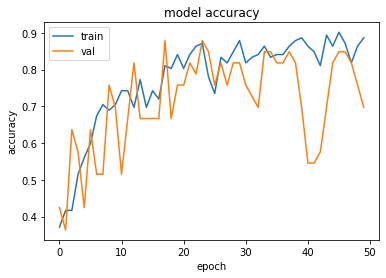

In [171]:
# Plot model accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

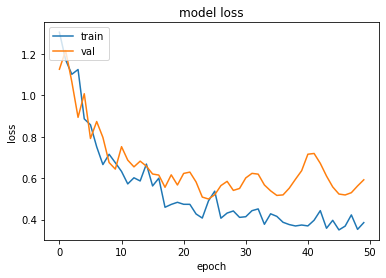

In [172]:
# Plot model loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

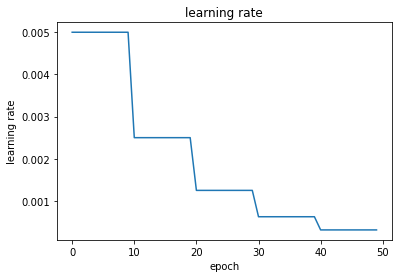

In [173]:
# Plot learning rate
plt.plot(history.history['lr'])
plt.title('learning rate')
plt.ylabel('learning rate')
plt.xlabel('epoch')
plt.show()

In [20]:
my_model.load_weights('weights.vgg16.best1.hdf5')

In [10]:
# Create a flow from the directory for test data
test_datagen = ImageDataGenerator(rescale=1./255)

test_gen = test_datagen.flow_from_directory(directory='test_dataset',
                                            target_size=(224,224),
                                            batch_size=1,
                                            shuffle=False,
#                                             save_to_dir='test_gen',
                                            class_mode='categorical')

Found 48 images belonging to 3 classes.


In [11]:
# Evaluate model on test set
scores = my_model.evaluate(test_gen)

48/48 [==============================] - 7s 152ms/step - loss: 0.7180 - accuracy: 0.7292


In [12]:
# Predict probabilities
prediction = my_model.predict(test_gen)

In [13]:
# Predict class based on highest probability
y_classes = prediction.argmax(axis=-1)
print(y_classes)

[0 0 0 0 0 0 0 2 0 1 0 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 2 1 2 0
 2 2 2 0 1 2 0 1 1 1 2]


In [14]:
# Output labels, Keras generator sorts the labels by alphabetical order
labels = ['dimension', 'grade', 'heat_number']
for i in y_classes:
    predicted_label = sorted(labels)[i]
    print(predicted_label)

dimension
dimension
dimension
dimension
dimension
dimension
dimension
heat_number
dimension
grade
dimension
grade
dimension
dimension
dimension
dimension
grade
grade
grade
grade
grade
grade
grade
grade
grade
grade
grade
grade
grade
grade
heat_number
grade
dimension
heat_number
grade
heat_number
dimension
heat_number
heat_number
heat_number
dimension
grade
heat_number
dimension
grade
grade
grade
heat_number
